In [1]:
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [6]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train,y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print("Training data shape", X_train.shape)
print('Training labels shape', y_train.shape)
print('Test data shape', X_test.shape)
print('Test labels shape', y_test.shape)

Training data shape (50000, 32, 32, 3)
Training labels shape (50000,)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000,)


show some sample of datasets

0 plane
1 car
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


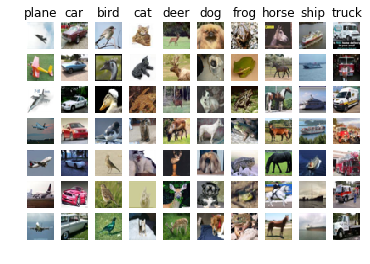

In [8]:
import numpy as np
import random
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
sample_per_class = 7
for y, cls in enumerate(classes):
    print(y, cls)
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, sample_per_class, replace=False)
#     print(idxs)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [16]:
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print(X_train.shape, y_train.shape)
print(X_test.shape)

(5000, 3072) (5000,)
(500, 3072)


In [17]:
# reshape 32 * 32 * 3 to 3072 
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [18]:
from cs231n.classifiers import KNN_classifier
classifier = KNN_classifier.KNearestNeighbor()
classifier.train(X_train, y_train)

In [19]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


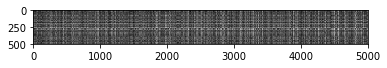

In [21]:
plt.imshow(dists, interpolation='none')
plt.show()

In [23]:
y_test_pred = classifier.predict_label(dists, k=1)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct / num_test)
print( 'There are %d correct result in all %d test examples' % (num_correct, num_test), ', and the accuracy is %0.5f' % accuracy)

There are 137 correct result in all 500 test examples , and the accuracy is 0.27400


In [24]:
y_test_pred = classifier.predict_label(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct / num_test)
print( 'There are %d correct result in all %d test examples' % (num_correct, num_test), ', and the accuracy is %0.5f' % accuracy)

There are 139 correct result in all 500 test examples , and the accuracy is 0.27800


In [29]:
dists_one = classifier.compute_distances_one_loop(X_test)
difference = np.linalg.norm(dists - dists_one, ord = 'fro')
print(type(difference))
print('Difference was : %f' % (difference,))
if difference < 0.0001:
    print('Good, the distance martices are the same')
else:
    print('OH, no, the distance matrices are different')

<class 'numpy.float64'>
Difference was : 0.000000
Good, the distance martices are the same


In [30]:
dists_zero = classifier.compute_distances_zero_loop(X_test)
difference = np.linalg.norm(dists - dists_zero, ord = 'fro')
print(type(difference))
print('Difference was : %f' % (difference,))
if difference < 0.0001:
    print('Good, the distance martices are the same')
else:
    print('OH, no, the distance matrices are different')

<class 'numpy.float64'>
Difference was : 0.000000
Good, the distance martices are the same


In [33]:
def time_function(f, *args):
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_zero_loop, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 21.065946 seconds
One loop version took 32.124053 seconds
No loop version took 0.066520 seconds


In [39]:
n_flods = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(X_train, n_flods)
print(y_train.shape, y_train.reshape(-1, 1).shape)
y_train_folds = np.array_split(y_train.reshape(-1, 1), n_flods)

(5000,) (5000, 1)


In [53]:
k_to_accuracies = {}

for k_ in k_choices:
    k_to_accuracies.setdefault(k_, [])

for i in range(n_flods):
    classifier = KNN_classifier.KNearestNeighbor()
    X_train_i = np.vstack(X_train_folds[0:i] + X_train_folds[i + 1:]) 
#     y_train_i = np.vstack(y_train_folds[0:i] + y_train_folds[i + 1:])
    y_train_i = np.vstack(y_train_folds[0:i] + y_train_folds[i + 1:])[:, 0]
    classifier.train(X_train_i, y_train_i)
    for k_ in k_choices:
        y_pred_i = classifier.predict(X_train_folds[i], k = k_)
        num_correct = np.sum(y_pred_i == y_train_folds[i][:, 0])
        accuracy_i = float(num_correct / X_train_folds[i].shape[0])
#         print(accuracy_i)
        k_to_accuracies[k_] = k_to_accuracies[k_] + [accuracy_i]
#         print(k_to_accuracies[k_], type(k_to_accuracies[k_]))

for k_ in sorted(k_to_accuracies):
    for accuracy_i in k_to_accuracies[k_]:
        print('accuracy is %0.5f when k value is %d' % (accuracy_i, k_))

accuracy is 0.26300 when k value is 1
accuracy is 0.25700 when k value is 1
accuracy is 0.26400 when k value is 1
accuracy is 0.27800 when k value is 1
accuracy is 0.26600 when k value is 1
accuracy is 0.23900 when k value is 3
accuracy is 0.24900 when k value is 3
accuracy is 0.24000 when k value is 3
accuracy is 0.26600 when k value is 3
accuracy is 0.25400 when k value is 3
accuracy is 0.24800 when k value is 5
accuracy is 0.26600 when k value is 5
accuracy is 0.28000 when k value is 5
accuracy is 0.29200 when k value is 5
accuracy is 0.28000 when k value is 5
accuracy is 0.26200 when k value is 8
accuracy is 0.28200 when k value is 8
accuracy is 0.27300 when k value is 8
accuracy is 0.29000 when k value is 8
accuracy is 0.27300 when k value is 8
accuracy is 0.26500 when k value is 10
accuracy is 0.29600 when k value is 10
accuracy is 0.27600 when k value is 10
accuracy is 0.28400 when k value is 10
accuracy is 0.28000 when k value is 10
accuracy is 0.26000 when k value is 12
accura

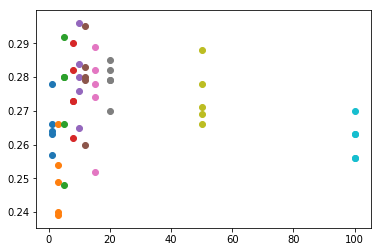

In [56]:
for k_ in k_choices:
    accuracies = k_to_accuracies[k_]
    plt.scatter([k_] * len(accuracies), accuracies)

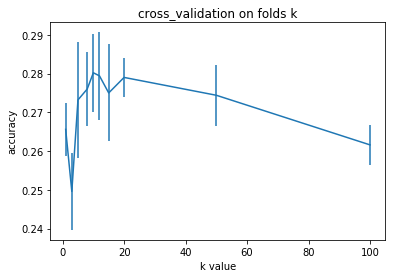

In [58]:
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())]) 
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('cross_validation on folds k')
plt.xlabel('k value')
plt.ylabel('accuracy')
plt.show()

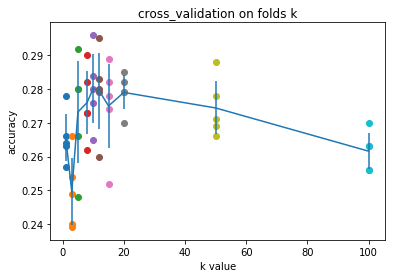

In [59]:
for k_ in k_choices:
    accuracies = k_to_accuracies[k_]
    plt.scatter([k_] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())]) 
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('cross_validation on folds k')
plt.xlabel('k value')
plt.ylabel('accuracy')
plt.show()

In [ ]:
best_k = 10
classifier = KNN_classifier.KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)
num_correct = np.sum(y_test_pred == y_test])
accuracy_i = float(num_correct / X_train_folds[i].shape[0])
print('accuracy is %0.5f when k value is %d' % (accuracy_i, k_))